<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/Statistical_Models_0722.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 통계 (ARIMA) 모델 : 단기 데이터에 유리, 선형 학습 기반  (예측 시간 길어질수록 오차 증가)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)
days = 5
points_per_day = 24*12
total_points = days * points_per_day
cpu = 50 + 20*np.sin(np.linspace(0, 15, total_points)) + np.random.normal(0, 3, total_points)
df = pd.DataFrame({'CPU rate': np.clip(cpu,0,100)})

# train/ test
split_ratio = 0.8
split_idx = int(len(df) * split_ratio)

train_data = df['CPU rate'][:split_idx]
test_data = df['CPU rate'][split_idx:]

# ADF 검정
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f"=== ADF Test: {title} ===")
    result = adfuller(series)
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value,label in zip(result[:4], labels):
        print(f"{label} : {value}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    if result[1] <= 0.05:
        print("✅ p-value <= 0.05 → 귀무가설 기각 → **정상성 있음**")
    else:
        print("❌ p-value > 0.05 → 귀무가설 채택 → **비정상 시계열**")
    print()

# 1. 원본 train_data 정상성 검정
adf_test(train_data, title='Original Train Data')

# 2. 1차 차분 후 정상성 검정
diff_series = train_data.diff().dropna()
adf_test(diff_series, title='1st Difference')

# 차분에서 정상 -> d = 1로 모델 피팅 (p,1,q)


=== ADF Test: Original Train Data ===
ADF Statistic : -0.7845653283222866
p-value : 0.8236138963491508
# Lags Used : 20
# Observations : 1131
Critical Value (1%): -3.4361450520165464
Critical Value (5%): -2.8640988637413893
Critical Value (10%): -2.5681324081722314
❌ p-value > 0.05 → 귀무가설 채택 → **비정상 시계열**

=== ADF Test: 1st Difference ===
ADF Statistic : -6.6312440348576835
p-value : 5.707822452507145e-09
# Lags Used : 19
# Observations : 1131
Critical Value (1%): -3.4361450520165464
Critical Value (5%): -2.8640988637413893
Critical Value (10%): -2.5681324081722314
✅ p-value <= 0.05 → 귀무가설 기각 → **정상성 있음**



In [10]:
# p,q 결정
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

best_aic = np.inf
best_order = None

for p in range(0,4):     # 0~3
    for q in range(0,4): # 0~3
        try:
            model = ARIMA(train_data, order=(p,1,q))
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p,1,q)
        except:
            continue

print("Best order:", best_order, " AIC:", best_aic)


Best order: (1, 1, 2)  AIC: 5852.535965456786


                               SARIMAX Results                                
Dep. Variable:               CPU rate   No. Observations:                 1152
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2922.268
Date:                Tue, 22 Jul 2025   AIC                           5852.536
Time:                        08:29:09   BIC                           5872.730
Sample:                             0   HQIC                          5860.158
                               - 1152                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9954      0.003    317.911      0.000       0.989       1.002
ma.L1         -1.9266      0.012   -166.206      0.000      -1.949      -1.904
ma.L2          0.9312      0.012     80.589      0.0

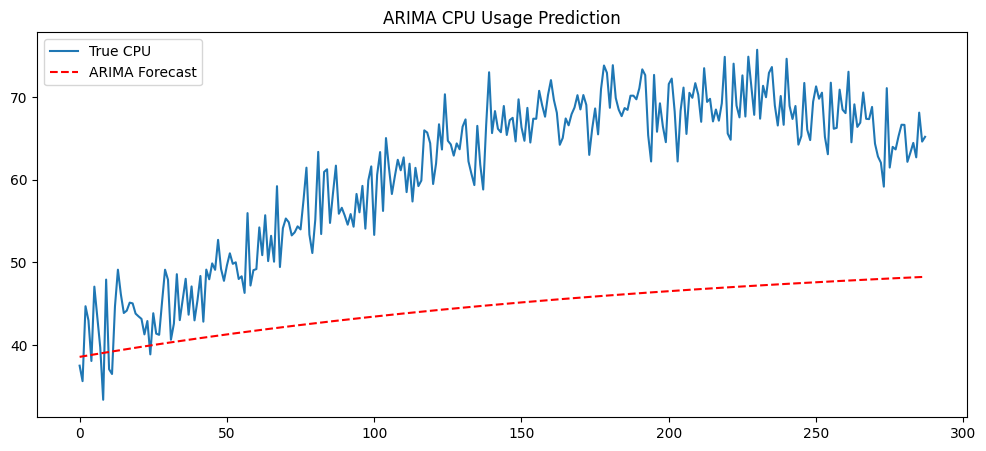

In [26]:
model = ARIMA(train_data, order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

# =========================
# 3. 예측 (테스트 길이만큼 멀티스텝 예측)
# =========================
forecast = model_fit.forecast(steps=len(test_data))
forecast = np.array(forecast) # 넘파이로 변환해서 0부터 인덱스 가능
# =========================
# 4. 성능 평가
# =========================
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae  = mean_absolute_error(test_data, forecast)
eps = 1e-6
mape = np.mean(np.abs((test_data - forecast) / (test_data + eps))) * 100
r2   = r2_score(test_data, forecast)

print("=== ARIMA 성능 ===")
print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# =========================
# 5. 시각화
# =========================
plt.figure(figsize=(12,5))
plt.plot(test_data.values, label="True CPU")
plt.plot(forecast, label="ARIMA Forecast", linestyle='--', color='red')
plt.legend()
plt.title("ARIMA CPU Usage Prediction")
plt.show()
